# Parallel Precondtioners
If we can construct a preconditioner with diagonal elements only, we can solve the error function on all collocation nodes in parallel, thus getting small scale parallelism, which is easy to implement.
Since the SDC sweeps become emberassingly parallel, we can get perfect speedup, as long as the preconditioner has the same contraction rate.
This is a somewhat ambitious goal and we will likely have to make some compromise, but [Speck](https://doi.org/10.1007/s00791-018-0298-x) showed that it is possible to get speedup.

They mostly derived parallel preconditioners using optimization for minimising the spectral radius of a "spatially independent" part of the iteration matrix for the Dahlquist problem.
We aim to do something similar here, where we want to optimise the number of iterations required to converge to a specific tolerance using adaptive time stepping.

## Adaptivity with embedded error estimate
Adaptive time stepping is often implemented using embedded methods, which compute two solutions of different order and subtract them.
The higher order solution acts as an approximation of the exact solution from the lower order methods point of view and so we get a reasonably good approxmation of the local error this way.

With spectral deferred corrections (SDC), this is a perticularly natural method to use because the order of the solution is expected to increase with each sweep, such that we only need to compare two iterates.
The reason why it is natural in this context, however, is that in SDC we approximate the error and subtract it from the solution in each sweep, meaning if we subtract to iterates, we get exactly the correction SDC has computed.

For most preconditioners, we know the order that they give in time and we can use that to compute an optimal step size for the next step based on the error estimate of the current step and the accuracy that we want to reach.
See [this notebook](https://github.com/Parallel-in-Time/pySDC/blob/master/pySDC/projects/Resilience/Adaptivity.ipynb#adaptivity) for details.

How can we use this to obtain diagonal preconditioners?
We make an objective function which takes as input the diagonal elements of the preconditioner and returns the number of iterations that we needed with this precondtioner:
$$K = C(\vec{\tau}),$$
where $K$ is the total number of iterations we needed, $C$ is the objective function and $\vec{\tau}$ is the vector carrying the diagonal elements of the preconditioner.
We let adaptivity take care that the accuracy of the solution is always the same.

In [1]:
from pySDC.playgrounds.Preconditioners.optimize_diagonal_preconditioner import objective_function_diagonal_adaptivity_embedded_normalized, args_advection
from pySDC.playgrounds.Preconditioners.diagonal_precon_sweeper import DiagPrecon
from pySDC.projects.Resilience.dahlquist import run_dahlquist, plot_stability, plot_contraction
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_nodes = 3
initial_guess = np.linspace(0, 1, num_nodes + 1)
#embedded_opt = minimize(objective_function_diagonal_adaptivity_embedded, initial_guess, args_advection, method='nelder-mead')

initial_guess = (np.arange(num_nodes - 1) + 1) / (num_nodes + 2)
tol = 1e-16
embedded_opt = minimize(objective_function_diagonal_adaptivity_embedded_normalized, initial_guess, args=args_advection, tol=tol,
                        method='nelder-mead')

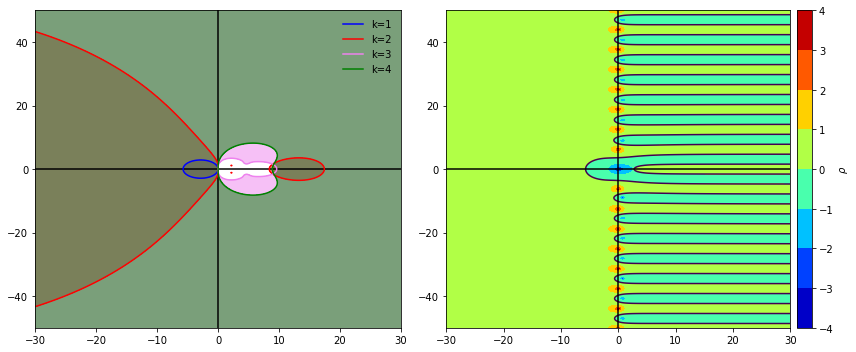

In [4]:
diags = np.append(embedded_opt.x, [1 - sum(embedded_opt.x)])

desc = {'sweeper_params': {'diagonal_elements': diags, 'first_row': np.zeros_like(diags)}, 'sweeper_class': DiagPrecon}
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
stats, c, _ = run_dahlquist(custom_description=desc)
plot_stability(stats, ax=axs[0], iter=[1, 2, 3, 4], fill=True)
plot_contraction(stats, fig=fig, ax=axs[1], plot_increase=True)
fig.tight_layout()


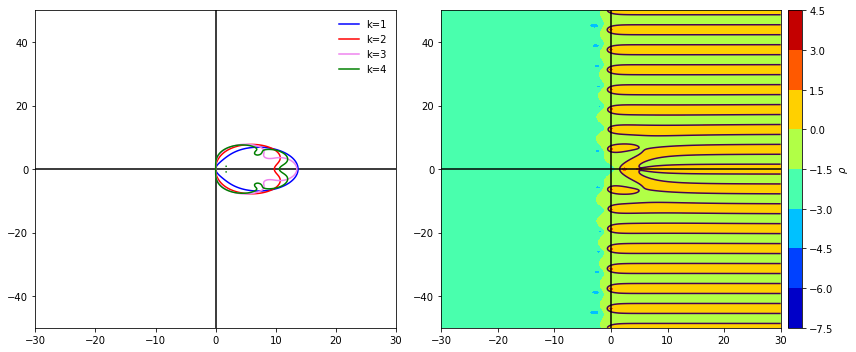

In [5]:
desc = {'sweeper_params': {'QI': 'LU'}}
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
stats_eu, _, _ = run_dahlquist(custom_description=desc)
plot_stability(stats_eu, ax=axs[0], iter=[1, 2, 3, 4], fill=False)
plot_contraction(stats_eu, fig=fig, ax=axs[1], plot_increase=True)
fig.tight_layout()

## Adaptivity based on the residual
The relationship between error and residual is not straightforward, but we can solve the equation for the step size.
Computing the step size requires inverting the preconditioner as well as evaluating the right hand side at the solution plus the accuracy to be reached.
While this is too expensive in most practical cases, we can easily invert a diagonal preconditioner and since we want to optimize preconditioners before the "production run", we can afford to perform the expensive right hand side evaluations.